In [12]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import random

# 1. Components of The Polya Process

 - **Initial Setup**: The network consists of investors (Silicon Valley Bank etc.), where each investor has an urn containing red balls (negative sentiment) and black balls (positive sentiment). The number of balls in each urn is based on the investor’s size and assets.
 - **Sentiment Contagion**: Each investor's urn is influenced by its neighbors through a super urn, which combines sentiment from all neighboring investors. If a red ball is drawn, negative sentiment increases in the investor's urn, and if a black ball is drawn, positive sentiment increases. The process mimics how rumors or sentiment spread across connected investors.
 - **Reinforcement of Assets**: When a sentiment ball is drawn, additional sentiment balls are added to the urn. The number of sentiment balls added depends on the investor's assets, as well as whether sentiment is positive or negative. For instance:
 -- **Positive Sentiment**: If a black ball is drawn, additional black balls are added based on the investor’s assets and the total assets of their neighboring institutions.
 -- **Negative Sentiment**: Similarly, if a red ball is drawn, additional red balls are added based on the same asset-weighted process.
 - **Group-based Asset Changes**: Depending on the proportion of positive or negative sentiment balls in an investor's urn, assets are either bought or sold. This is grouped into two categories:
 -- **Group 1**: If positive sentiment is between 50-75%, a fraction of the investor’s assets are bought (10%).
 -- **Group 2**: If positive sentiment exceeds 75%, more assets are bought (20%).

# 2. Metro Bank Simulation

**Investors**:
 - Private Shareholders (142 nodes): Holding **243,515** shares.
 - Banks (3 nodes): Holding **10,210** shares.
 - Nominees (392 nodes): Holding **95,164,712** shares.
 Each investor is represented by a node, and their sentiment (positive (black) to negative (red) will influence how assets are reinforceed or diminished. 
 
**Goals**:
 - Model the spread of sentiment over a time period of **??1 Months (30 Steps)??**
 - Vizualize the impact on each investor by node size and colour gradient
 - Track the total sentiment
 - Vizualization of the contagion spreading and the nodes changing dynamically. 

In [13]:
def initialize_investor_groups():
    investors = {
        'Shareholders': {'initial_assets': 2243515, 'current_assets': 2243515, 'sentiment': 95, 'steps_since_change': 0},
        'Banks': {'initial_assets': 10210, 'current_assets': 10210, 'sentiment': 85, 'steps_since_change': 0},
        'Nominees': {'initial_assets': 95164712, 'current_assets': 95164712, 'sentiment': 90, 'steps_since_change': 0}
    }
    return investors

In [14]:
# simulating Metro Bank crisis
def update_sentiment(investors, step):
    # crisis events at steps 
    if step == 10:
        for group in investors:
            investors[group]['sentiment'] -= 10  # external event causes drop
            investors[group]['steps_since_change'] = 0  # reset counter - a major change just occurred
    elif step == 20:
        for group in investors:
            investors[group]['sentiment'] -= 15  # another sentiment drop
            investors[group]['steps_since_change'] = 0
    elif step == 30:
        for group in investors:
            investors[group]['sentiment'] += 5  # positive sentiment event (EXPERIMENT)
            investors[group]['steps_since_change'] = 0

    # natural shifts after no change for 3 steps
    apply_natural_shift(investors)
    # bound sentiment 10 to 100
    for group in investors:
        investors[group]['sentiment'] = max(10, min(100, investors[group]['sentiment']))

In [15]:
# natural shift 
def apply_natural_shift(investors):
    for group in investors:
        # if 3 steps have passed since last major sentiment change
        if investors[group]['steps_since_change'] >= 3:
            # small natural shift
            random_shift = random.uniform(0.005, 0.02)  # shift between 0.5% and 2%
            if investors[group]['sentiment'] < 100:
                investors[group]['sentiment'] *= (1 - random_shift)  # decrease in sentiment
            else:
                investors[group]['sentiment'] *= (1 + random_shift)  # increase if sentiment was rising
        # counter since last major change
        investors[group]['steps_since_change'] += 1

In [16]:
# assets based on proportional sentiment change
def update_assets(investors, prev_sentiment):
    for group in investors:
        # change in sentiment
        current_sentiment = investors[group]['sentiment']
        delta_sentiment = current_sentiment - prev_sentiment[group]

        # update assets proportionally to the sentiment change
        if delta_sentiment < 0:
            # decrease assets proportional to the magnitude of sentiment drop
            sentiment_proportional_drop = abs(delta_sentiment) / prev_sentiment[group]
            investors[group]['current_assets'] *= (1 - sentiment_proportional_drop)
        elif delta_sentiment > 0:
            # increase assets "---"
            sentiment_proportional_rise = delta_sentiment / prev_sentiment[group]
            investors[group]['current_assets'] *= (1 + sentiment_proportional_rise)

        investors[group]['current_assets'] = max(5000, investors[group]['current_assets'])  # prevent a collapse

In [17]:
# Plot infection rate
def plot_infection_rate(sentiment_history):
    infection_rate = []
    total_investors = len(sentiment_history)
    for step in range(len(list(sentiment_history.values())[0])):
        infected_count = sum(1 for sentiments in sentiment_history.values() if sentiments[step] < 50)
        infection_rate.append(infected_count / total_investors)

    plt.figure(figsize=(10, 2.5))
    plt.plot(infection_rate, color='red', label="Infection Rate")
    plt.xlabel("Step")
    plt.ylabel("Infection Rate")
    plt.title("Infection Rate Over Time")
    plt.legend()
    plt.show()

In [18]:
# Define custom colors for groups
group_colors = {
    "Shareholders": "purple",  # Dark purple for shareholders
    "Banks": "red",            # Red for banks
    "Nominees": "grey"         # Grey for nominees
}

# Function to calculate and plot network susceptibility
def plot_network_susceptibility(sentiment_history, asset_history):
    plt.figure(figsize=(10, 2.5))
    
    # Calculate network susceptibility for each group
    for group, sentiments in sentiment_history.items():
        susceptibilities = [
            sentiments[t] / 100  # Normalize sentiment to a proportion
            for t in range(len(sentiments))
        ]
        plt.plot(susceptibilities, label=group, color=group_colors.get(group, "black"))

    # Customize plot
    plt.xlabel("Step")
    plt.ylabel("Network Susceptibility")
    plt.title("Network Susceptibility Over Time")
    plt.legend()
    plt.show()


In [19]:
def visualize_simulation(investors, steps=40):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xlim(-2, 2)
    ax.set_ylim(-2, 2)

    # Fixed positions for the investor groups
    positions = np.array([[-0.15, 0.3], [0, 0], [-0.3, 0]])

    # Store sentiment and percentage asset changes over time
    sentiment_history = {group: [] for group in investors}
    asset_percentage_history = {group: [] for group in investors}

    # Initialize previous sentiment tracker
    prev_sentiment = {group: investors[group]['sentiment'] for group in investors}

    # Calculate relative asset size
    def relative_asset_size(group):
        return investors[group]['current_assets'] / investors[group]['initial_assets']

    # Plot for visualization
    def update_plot(step):
        ax.clear()
        update_sentiment(investors, step)  # Update sentiment at each step
        update_assets(investors, prev_sentiment)  # Update assets based on sentiment change

        # Update previous sentiment for the next step
        prev_sentiment.update({group: investors[group]['sentiment'] for group in investors})

        # Store the ball sizes and colors
        sizes = []
        colors = []

        # Iterate through the investor groups to update size and color
        for i, group in enumerate(investors):
            relative_size = relative_asset_size(group)
            sizes.append(relative_size * 1000)
            sentiment = investors[group]['sentiment']
            colors.append((1 - sentiment / 100, 0, 0))  # Gradient from red to black

            # Store sentiment and percentage asset change
            sentiment_history[group].append(sentiment)
            asset_percentage_history[group].append(relative_size * 100)

        # Plot for the 3 investors
        scatter = ax.scatter(positions[:, 0], positions[:, 1], s=sizes, color=colors, alpha=0.8)

        # Lines (connections) between the investors
        for i in range(len(positions)):
            for j in range(i + 1, len(positions)):
                ax.plot([positions[i, 0], positions[j, 0]], [positions[i, 1], positions[j, 1]], color='black', alpha=0.5)

        for i, group in enumerate(investors):
            ax.text(positions[i, 0], positions[i, 1] + 0.1, f"{group}\nAssets: {int(investors[group]['current_assets'])}",
                    ha='center', fontsize=12)

        ax.set_title(f"Step {step + 1}")
        ax.axis("off")  # Remove gridlines and axes

    anim = animation.FuncAnimation(fig, update_plot, frames=steps, interval=500)

    # Display the animation inline in the notebook
    return HTML(anim.to_jshtml()), sentiment_history, asset_percentage_history

In [20]:
def plot_sentiment_history(sentiment_history):
    
    colors = {
        "shareholders": "purple",
        "banks": "red",
        "nominees": "grey"
    }
    
    plt.figure(figsize=(10, 6))
    for group, sentiments in sentiment_history.items():
        plt.plot(sentiments, label=group, color=colors.get(group, "black"))
        
    plt.xlabel("Step")
    plt.ylabel("Sentiment")
    plt.title("Sentiment Change Over Time")
    plt.legend()
    plt.show()

In [21]:
def plot_sentiment_history(sentiment_history):
    # Define custom colors for each group
    colors = {
        "Shareholders": "purple",  # Dark purple for shareholders
        "Banks": "red",            # Red for banks
        "Nominees": "grey"         # Grey for nominees
    }

    plt.figure(figsize=(10, 2))
    
    # Plot each group with their respective color
    for group, sentiments in sentiment_history.items():
        plt.plot(sentiments, label=group, color=colors.get(group, "black"))  # Default to black if group not in colors
    
    plt.xlabel("Step")
    plt.ylabel("Sentiment")
    plt.title("Sentiment Change Over Time")
    plt.legend()
    plt.show()


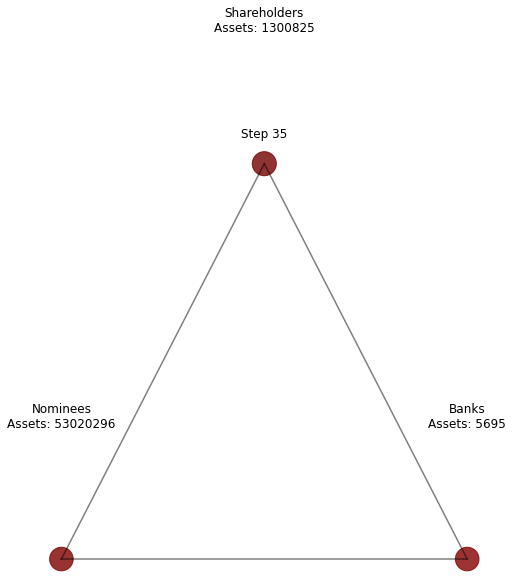

In [22]:
# Initialize investors and run visualization
investors = initialize_investor_groups()
animation_html, sentiment_history, asset_percentage_history = visualize_simulation(investors, steps=35)

# Display animation
animation_html  # Directly display the animation HTML object in the notebook


AttributeError: 'HTML' object has no attribute 'to_jshtml'

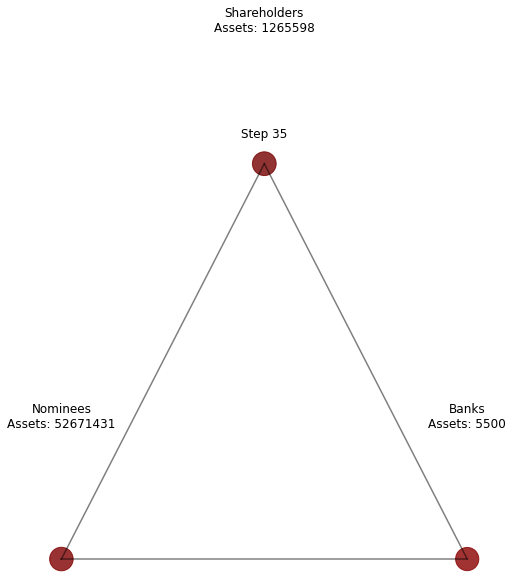

In [23]:
investors = initialize_investor_groups()

anim, sentiment_history, asset_percentage_history = visualize_simulation(investors, steps=35)
HTML(anim.to_jshtml())

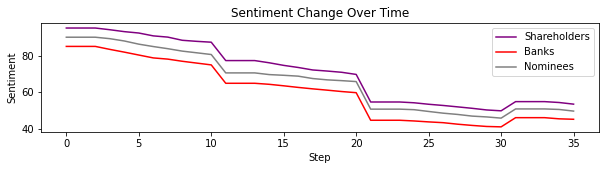

NameError: name 'plot_asset_percentage_history' is not defined

In [24]:
plot_sentiment_history(sentiment_history)
plot_asset_percentage_history(asset_percentage_history)

##  2.1 Improvements

 - Possibly add a def function that gives meaning to the investors position on the map, whether it is shared assets that draw them in closer etc.

In [ ]:
// Define the structure for an Investor Node
class InvestorNode {
    constructor(investor_id, strength_of_opinion) {
        this.id = investor_id;                   // Unique identifier for the investor
        this.strength = strength_of_opinion;     // Investor's opinion strength (-1 to 1)
        this.parents = [];                        // List of parent investors (should be empty for the root)
        this.children = [];                       // List of child investors
        this.sentiment_mean = 0;                  // Mean sentiment (G_i(t))
        this.sentiment_variance = 0;              // Variance (σ^2_i(t)) of the sentiment
        this.mean_reversion_rate = 0.05;         // Mean-reversion rate (α_i)
        this.volatility = 0.3;                   // Volatility (σ_i)
        this.external_shocks_intensity = 0.05;   // Intensity of external shocks (λ_i)
        this.impact_external_shocks = 0.5;       // Impact of external shocks (χ_i)
        this.jump_process = [];                   // List of external shocks encountered by the investor
        this.neighbors = [];                      // List of neighboring investors (connected nodes)
        this.R = 0;                              // Count of red balls (negative sentiment)
        this.B = 0;                              // Count of black balls (positive sentiment)
        this.history = [];                        // Store the history of draws (Z_i,t)
        this.assets = 0;                         // Number of assets held by the investor
        this.sentiment_urn = new Urn();          // Initialize an urn for sentiments
        this.company_data = {};                   // Company data containing risk level
    }
}

// Define the structure for the Urn that holds sentiment results
class Urn {
    constructor() {
        this.red_balls = 0;                     // Count of positive sentiment (red balls)
        this.black_balls = 0;                   // Count of negative sentiment (black balls)
    }

    // Function to add a ball to the urn based on the sentiment value
    addBall(sentiment) {
        if (sentiment > 0) {
            this.red_balls += 1;                // Increment red ball count for positive sentiment
        } else {
            this.black_balls += 1;              // Increment black ball count for negative sentiment
        }
    }
}

// Define the structure for the Investor Tree
class InvestorTree {
    constructor(root_investor) {
        this.root = root_investor;              // The top investor (root) in the tree
    }

    addChild(parent_investor, child_investor) {
        parent_investor.children.push(child_investor); // Append child to parent's children list
        child_investor.parents.push(parent_investor);   // Append parent to child's parents list
    }

    calculateInfluence(investor) {
        let influence = 0;                      // Initialize total influence to zero
        for (let parent of investor.parents) {
            influence += (k * parent.hierarchical_level() * P_influence(parent, investor));
        }
        return influence; // Return the total influence on the current investor
    }
}

// Function to generate a Wiener process increment for sentiment randomness
function generateWienerProcess(volatility) {
    return NormalDistribution(0, volatility); // Generate a normally distributed random value
}

// Function to generate a Poisson process increment to model external shocks
function generatePoissonProcess(lambda) {
    return PoissonDistribution(lambda); // Generate a Poisson-distributed random value
}

// Function to calculate the variance for an investor's sentiment
function calculateVariance(investor) {
    return investor.sentiment_variance; // Placeholder to return current sentiment variance
}

// Function to integrate decay from past shocks for sentiment calculations
function integrateDecay(influencer, current_time) {
    let decay_integral = 0;                 // Initialize decay integral
    for (let past_shock of influencer.jump_process) {
        let decay_time = current_time - past_shock.time; // Time since the past shock occurred
        decay_integral += Math.exp(-decay_time); // Exponential decay of influence
    }
    return decay_integral; // Return the accumulated decay integral
}

// Function to update the sentiment of an investor based on the SDE
function updateSentiment(investor, time, dt) {
    let random_influence = generateWienerProcess(investor.volatility) * Math.sqrt(dt); // Stochastic term
    let influence_sum = investor.calculateInfluence(); // Influence from parents

    // Calculate external shock impact
    let external_shock = investor.jump_process.reduce((acc, shock) => acc + shock, 0);

    // Update sentiment dynamics using the SDE
    let dGi = -investor.mean_reversion_rate * investor.sentiment_mean * dt +
              random_influence +
              influence_sum * dt +
              investor.impact_external_shocks * external_shock;

    investor.sentiment_mean += dGi; // Update the investor's mean sentiment
    investor.sentiment_variance = calculateVariance(investor); // Update the variance of sentiment
}

// Function to update external shocks encountered by an investor
function updateExternalShocks(investor) {
    let poisson_process = generatePoissonProcess(investor.external_shocks_intensity); // Generate a Poisson process
    investor.jump_process.push(poisson_process); // Append the new shock to the investor's jump process
}

// Function to calculate the intensity of shocks using the Hawkes process
function updateShockIntensity(investor, time) {
    let baseline_intensity = investor.external_shocks_intensity; // μ_i
    let total_influence = 0;                     // Initialize total influence

    // Loop through influencers to calculate their effect on shock intensity
    for (let influencer of investor.influencers) {
        let decay_contribution = integrateDecay(influencer, time); // Integral of past shocks
        total_influence += influencer.hierarchical_level() * decay_contribution;
    }

    investor.external_shocks_intensity = baseline_intensity + total_influence; // Update shock intensity
}

// Function to define causal relationships in a Bayesian network
function calculateCausalRelationship(investor) {
    let parent_sentiments = getParentSentiments(investor); // Get sentiments from parent investors
    let external_factors = getExternalFactors(investor);    // Get external factors affecting sentiment

    return f(investor.sentiment_mean, parent_sentiments, external_factors); // Calculate conditional probability
}

// Function to load company data and investor information from a text file
function loadCompanyData(file_path) {
    let company_data = {}; // Initialize a dictionary to hold company and investor data
    let file = open(file_path, "r"); // Open the file for reading
    for (let line of file) {
        let company_info = line.split(","); // Split the line by commas
        let company_name = company_info[0]; // Get company name
        let num_investors = parseInt(company_info[1]); // Get number of investors
        let risk_level = company_info[2].trim(); // Get risk level and strip whitespace

        if (!(company_name in company_data)) {
            company_data[company_name] = {
                investors: [],
                urn: new Urn(),
                risk_level: risk_level // Store the risk level
            };
        }
        
        // Generate investors with randomized opinions based on the specified number
        for (let i = 1; i <= num_investors; i++) {
            let strength_of_opinion = randomUniform(-1.0, 1.0); // Random opinion between -1 and 1
            let investor = new InvestorNode(company_name + "_Investor_" + i, strength_of_opinion); // Create a new investor node
            investor.company_data = { risk_level: risk_level }; // Set the investor's company data
            company_data[company_name].investors.push(investor); // Add investor to the company's list
        }
    }
    file.close(); // Close the file after reading
    return company_data; // Return the structured company data
}

// Function to initialize the super urn for each investor based on their neighbors
function initializeSuperUrns(network) {
    for (let investor of network.nodes.values()) {
        investor.superR = 0; // Initialize super urn red balls
        investor.superB = 0; // Initialize super urn black balls
        investor.superT = 0; // Initialize total balls
        
        // Collect balls from self and neighbors
        investor.superR += investor.R;
        investor.superB += investor.B;
        for (let neighbor of investor.neighbors) {
            investor.superR += neighbor.R;
            investor.superB += neighbor.B;
        }
        investor.superT = investor.superR + investor.superB; // Total balls in the super urn
    }
}

// Function to draw from the super urn and update each investor's urn
function drawFromSuperUrns(network) {
    for (let investor of network.nodes.values()) {
        // Calculate total balls and their weights based on risk levels
        if (investor.superT > 0) { // Ensure there's at least one ball to draw
            let draw = randomUniform(0, investor.superT); // Random draw from total

            // Get the investor's company risk level
            let company_risk = investor.company_data.risk_level; // Assuming company_data holds risk level

            if (draw < investor.superR) { // If drawn ball is red
                investor.R += deltaR(investor); // Add red balls based on some function
                investor.history.push(1); // Record draw result (red)
                // Transfer sentiment based on risk
                for (let neighbor of investor.neighbors) {
                    let neighbor_company_risk = neighbor.company_data.risk_level;
                    if (company_risk === "risky" && neighbor_company_risk === "risky") {
                        neighbor.R += deltaR(neighbor); // Transfer more red balls to risky neighbors
                    } else if (company_risk === "medium risk") {
                        neighbor.R += Math.floor(deltaR(neighbor) * 0.5); // Medium risk neighbors receive less
                    }
                    // No transfer for low risk neighbors
                }
            } else { // If drawn ball is black
                investor.B += deltaB(investor); // Add black balls based on some function
                investor.history.push(0); // Record draw result (black)
                // Transfer sentiment based on risk
                for (let neighbor of investor.neighbors) {
                    let neighbor_company_risk = neighbor.company_data.risk_level;
                    if (company_risk === "risky" && neighbor_company_risk === "risky") {
                        neighbor.B += deltaB(neighbor); // Transfer more black balls to risky neighbors
                    } else if (company_risk === "medium risk") {
                        neighbor.B += Math.floor(deltaB(neighbor) * 0.5); // Medium risk neighbors receive less
                    }
                    // No transfer for low risk neighbors
                }
            }
        }
        investor.calculateTotalBalls(); // Update total after draw
    }
}

// Function to calculate how many red balls to add based on drawing results
function deltaR(investor) {
    return Math.floor(randomUniform(1, 3)); // Example: add 1 to 2 red balls based on random uniform distribution
}

// Function to calculate how many black balls to add based on drawing results
function deltaB(investor) {
    return Math.floor(randomUniform(1, 3)); // Example: add 1 to 2 black balls based on random uniform distribution
}

// Function to calculate the negative perception metric for each investor
function calculateNegativePerception(investor) {
    let U = investor.R + sum(investor.history.slice(-M).map(x => deltaR(investor))); // Only consider last M draws
    return U / investor.T; // Normalize by total balls
}

// Function to calculate the average negative sentiment spread in the network
function calculateAverageSentiment(network) {
    let totalRed = 0;                         // Initialize total count of red balls
    let totalBalls = 0;                       // Initialize total count of balls
    for (let investor of network.nodes.values()) {
        totalRed += investor.R; // Accumulate total red balls
        totalBalls += investor.T; // Accumulate total balls
    }
    return totalRed / totalBalls; // Average proportion of red balls in the network
}

// Main simulation loop for processing sentiment for each company
function simulateInvestorSentiment(company_data, time_steps) {
    for (let company in company_data) { // Loop through each company
        let root_investor = company_data[company].investors[0]; // Set the first investor as the root
        let investor_tree = new InvestorTree(root_investor); // Create a new tree with the root investor

        // Add child investors to the root investor in the tree
        for (let investor_info of company_data[company].investors.slice(1)) {
            investor_tree.addChild(root_investor, investor_info); // Establish parent-child relationships
        }

        // Simulate sentiment dynamics over specified time steps
        for (let time of time_steps) {
            let dt = calculateTimeStep(time); // Calculate the time increment for the current step
            for (let investor of investor_tree.root.children) { // Loop through each child investor
                updateSentiment(investor, time, dt); // Update each child's sentiment
                updateExternalShocks(investor);      // Check for new external shocks
                updateShockIntensity(investor, time); // Update intensity of shocks
                calculateCausalRelationship(investor); // Update causal relationships
            }

            // After all child investors, update the root investor's sentiment
            updateSentiment(root_investor, time, dt);
        }

        // Initialize super urns for sentiment spread
        initializeSuperUrns(company_data[company].investors);

        // Draw from super urns and update sentiments
        drawFromSuperUrns(company_data[company].investors);

        // Add the final sentiment of the root investor to the urn based on its sentiment
        let urn = company_data[company].urn;
        urn.addBall(root_investor.sentiment_mean); // Update urn with root investor's final sentiment

        // Print the final results for each company
        print("Company:", company); // Print the company's name
        print("Red balls (positive sentiment):", urn.red_balls); // Print count of positive sentiment
        print("Black balls (negative sentiment):", urn.black_balls); // Print count of negative sentiment
    }
}

// Initialize and run the model
let file_path = "path/to/investor_data.txt"; // Specify the path to the data file
let company_data = loadCompanyData(file_path); // Load company data from the file
let time_steps = generateTimeSteps(); // Generate time steps for simulation
simulateInvestorSentiment(company_data, time_steps); // Execute the simulation

// New Section: Reinforcement Process

// Function to initialize investors with random sizes, assets, and sentiment balls
function initializeInvestors(num_investors) {
    let investors = []; // List to hold initialized investors
    for (let i = 0; i < num_investors; i++) {
        let size = randomUniform(0, 100); // Random size for the investor
        let assets, sentiment_balls;
        
        if (size < 15) {
            // Large investor
            assets = randomUniform(2000, 3000); // Assets for large investor
            sentiment_balls = randomUniform(150, 250); // Sentiment balls for large investor
        } else if (size < 40) {
            // Medium investor
            assets = randomUniform(750, 1500); // Assets for medium investor
            sentiment_balls = randomUniform(50, 100); // Sentiment balls for medium investor
        } else {
            // Small investor
            assets = randomUniform(100, 250); // Assets for small investor
            sentiment_balls = randomUniform(10, 20); // Sentiment balls for small investor
        }
        
        // Create new investor node with initial assets and sentiment balls
        let investor = new InvestorNode("Investor_" + i, randomUniform(-1.0, 1.0)); // Create a new investor node
        investor.assets = assets; // Set initial assets
        investor.sentiment_urn.red_balls = sentiment_balls; // Set initial sentiment balls
        investors.push(investor); // Add investor to the list
    }
    return investors; // Return initialized investors
}

// Function to perform reinforcement process for sentiment balls
function reinforceSentiment(investor) {
    let draw = drawFromSuperUrn(); // Assuming a function that draws from the super urn

    if (draw > 0) { // If positive sentiment ball is drawn
        let delta_b = (investor.assets / total_assets) * 100; // Calculate balls to add based on assets
        investor.sentiment_urn.addBall(1); // Add the drawn ball back
        investor.sentiment_urn.addBall(delta_b); // Add additional sentiment balls

        // Determine asset actions based on sentiment
        if (investor.sentiment_urn.red_balls / (investor.sentiment_urn.red_balls + investor.sentiment_urn.black_balls) >= 0.5) {
            // Group 1: If positive sentiment between 50% and 75%, add assets
            if (investor.assets * 0.1 + investor.assets <= 2 * initial_assets) {
                investor.assets += investor.assets * 0.1; // Add assets
            }
        } else if (investor.sentiment_urn.red_balls / (investor.sentiment_urn.red_balls + investor.sentiment_urn.black_balls) > 0.75) {
            // Group 2: If positive sentiment exceeds 75%, add assets more aggressively
            if (investor.assets * 0.2 + investor.assets <= 2 * initial_assets) {
                investor.assets += investor.assets * 0.2; // Add more assets
            }
        }
    } else { // If negative sentiment ball is drawn
        let delta_r = (investor.assets / total_assets) * 100; // Calculate balls to remove based on assets
        investor.sentiment_urn.addBall(-1); // Add the drawn ball back
        investor.sentiment_urn.addBall(-delta_r); // Add additional negative sentiment balls

        // Determine asset actions based on sentiment
        if (investor.sentiment_urn.black_balls / (investor.sentiment_urn.red_balls + investor.sentiment_urn.black_balls) >= 0.5) {
            // Group 1: If negative sentiment between 50% and 75%, remove assets
            if (investor.assets - (investor.assets * 0.1) >= 0) {
                investor.assets -= investor.assets * 0.1; // Remove assets
            }
        } else if (investor.sentiment_urn.black_balls / (investor.sentiment_urn.red_balls + investor.sentiment_urn.black_balls) > 0.75) {
            // Group 2: If negative sentiment exceeds 75%, remove assets more aggressively
            if (investor.assets - (investor.assets * 0.2) >= 0) {
                investor.assets -= investor.assets * 0.2; // Remove more assets
            }
        }
    }
}

// Function to simulate natural asset growth for each investor
function simulateNaturalGrowth(investor) {
    investor.assets += investor.assets * natural_growth_rate; // Apply natural growth to assets
}

// Main loop for reinforcement process across the network
function simulateReinforcement(investors) {
    for (let investor of investors) {
        reinforceSentiment(investor); // Apply reinforcement process
        simulateNaturalGrowth(investor); // Simulate natural asset growth
    }
}

// Initialize investors and simulate reinforcement
let num_investors = 100; // Total number of investors
let investors = initializeInvestors(num_investors); // Initialize investors with assets and sentiments
simulateReinforcement(investors); // Execute the reinforcement simulation

# 0. Appendix (Predictive Modeling / Importing Sentiment Data)

In [ ]:
import pandas as pd
import requests

In [ ]:
# function to fetch news sentiment data from FMP (Can be drawn from anywhere - first thing I found)
def fetch_news_df(api_key, page):
    url = f'https://financialmodelingprep.com/api/v4/stock-news-sentiments-rss-feed?page={page}&apikey={api_key}'
    response = requests.get(url).json()
    return pd.DataFrame(response)

api_key = 'qhj17FO7DWK1NGTrdbcsxws2MkzANCAu'
news_data = fetch_news_df(api_key, page=0)
news_data.head()

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder

def preprocess_news_data(data):
    data = data.dropna()
    le = LabelEncoder()
    data['sentiment'] = le.fit_transform(data['sentiment'])
    
    vectorizer = CountVectorizer(max_features=1000)
    text_vector = vectorizer.fit_transform(data['text'])
    return data, text_vector, le, vectorizer

news_data, text_vector, le, vectorizer = preprocess_news_data(news_data)

# can experiment with TF-IDF (Term Frequency-Inverse Document Frequency) instead of Count Vectorizer for a more 
# complex feature representation.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import BernoulliNB
from xgboost import XGBClassifier

X = df_hb1_nocont_sentilink.drop(columns = ['no_contact'])
y = df_hb1_nocont_sentilink['no_contact']

X_hb1nc_sentilink_train, X_hb1nc_sentilink_other, y_hb1nc_sentilink_train, y_hb1nc_sentilink_other = train_test_split(X, y, test_size=0.3, random_state=42)
X_hb1nc_sentilink_vald, X_hb1nc_sentilink_test, y_hb1nc_sentilink_vald, y_hb1nc_sentilink_test = train_test_split(X_hb1nc_sentilink_other, y_hb1nc_sentilink_other, test_size=0.5, random_state=42)

In [ ]:
model_hb1nc_sentilink = XGBClassifier(n_estimators=100, random_state=42, use_label_encoder=False, eval_metric='logloss')
model_hb1nc_sentilink.fit(X_hb1nc_sentilink_train, y_hb1nc_sentilink_train)

In [ ]:
y_pred_hb1nc_sentilink = model_hb1nc_sentilink.predict(X_hb1nc_sentilink_test)
y_pred_prob_hb1nc_sentilink = model_hb1nc_sentilink.predict_proba(X_hb1nc_sentilink_test)[:, 1]
accuracy_hb1nc_sentilink = accuracy_score(y_hb1nc_sentilink_test, y_pred_hb1nc_sentilink)
roc_auc_hb1nc_sentilink = roc_auc_score(y_hb1nc_sentilink_test, y_pred_prob_hb1nc_sentilink)
precision, recall, thresholds = precision_recall_curve(y_hb1nc_sentilink_test, y_pred_prob_hb1nc_sentilink, pos_label=1)

print('AUC PR score for hb1 no contact sentilink: ' + str(metrics.auc(recall, precision)))
print(f"Accuracy score for hb1 no contact sentilink: {accuracy_hb1nc_sentilink}")
print(f"ROC AUC Score for hb1 no contact sentilink: {roc_auc_hb1nc_sentilink}")

In [ ]:
# calculate 'scale_pos_weight' as sum(negative class)/sum(positive class)
scale_pos_weight = y_hb1nc_sentilink_train.value_counts()[0] / y_hb1nc_sentilink_train.value_counts()[1]
round(scale_pos_weight,2)

In [ ]:
eval_set = [(X_hb1nc_sentilink_train, y_hb1nc_sentilink_train), (X_hb1nc_sentilink_vald, y_hb1nc_sentilink_vald)]

def train_model(n_estimators, subsample, reg_lambda, reg_alpha, min_child_weight, max_depth, learning_rate, colsample_bytree):
    params = {
        'n_estimators': int(round(n_estimators)),
        'subsample': subsample,
        'reg_lambda': int(round(reg_lambda)),
        'reg_alpha': int(round(reg_alpha)),
        'min_child_weight': round(min_child_weight),
        'max_depth': int(round(max_depth)),
        'learning_rate': learning_rate,
        'colsample_bytree': colsample_bytree
    }
    xgbc_hb1nc = XGBClassifier(n_jobs = -1, eval_metric = ['error','aucpr'], early_stopping_rounds=20, objective='binary:logistic', **params, scale_pos_weight = scale_pos_weight)
    xgbc_hb1nc.fit(X_hb1nc_sentilink_train, y_hb1nc_sentilink_train, eval_set=eval_set, verbose=50)
    return xgbc_hb1nc.evals_result()['validation_1']['aucpr'][-1]

xgb_param_grid = {
    'n_estimators' : (50, 201),
    'subsample': (0.7, 0.95),
    'reg_lambda': (1, 60),
    'reg_alpha': (1, 20), 
    'min_child_weight':(10, 51),
    'max_depth' : (2, 3),
    'learning_rate' : (0.01, 0.2),
    'colsample_bytree': (0.6, 0.95)
}

optimizer = BayesianOptimization(
    f=train_model,
    pbounds=xgb_param_grid,
    #random_state=1,
)
optimizer.maximize(init_points=2, n_iter=23)
 
print(optimizer.max)

In [ ]:
xgbc_hb1nc.get_xgb_params()

In [ ]:
print("Train full model with the best hyperparameter set...")
 
 
eval_set = [(X_hb1nc_sentilink_train, y_hb1nc_sentilink_train), (X_hb1nc_sentilink_vald, y_hb1nc_sentilink_vald)]
xgbc_hb1nc = XGBClassifier(n_estimators = int(optimizer.max['params']['n_estimators']), 
                         n_jobs = -1, 
                         subsample = round(optimizer.max['params']['subsample'],2), 
                         reg_lambda = round(optimizer.max['params']['reg_lambda'],2), 
                         reg_alpha = round(optimizer.max['params']['reg_alpha'],2),
                         min_child_weight = round(optimizer.max['params']['min_child_weight'],2),
                         max_depth = int(optimizer.max['params']['max_depth']), 
                         learning_rate= round(optimizer.max['params']['learning_rate'],2),  
                         colsample_bytree = round(optimizer.max['params']['colsample_bytree'],2), 
                         scale_pos_weight = scale_pos_weight,
                         objective='binary:logistic',
                         eval_metric = ['error','aucpr'],
                         early_stopping_rounds=20
                        )
 
## model used for values below as it takes the best hyperparameter class 
xgbc_hb1nc.fit(X_hb1nc_sentilink_train, y_hb1nc_sentilink_train, eval_set=eval_set, verbose=50)

#AUC
simple_split_pred_train = xgbc_hb1nc.predict_proba(X_hb1nc_sentilink_train)
fpr, tpr, thresholds = metrics.roc_curve(y_hb1nc_sentilink_train, simple_split_pred_train[:,1], pos_label=1)
print('AUC full train set: ' + str(metrics.auc(fpr, tpr)))
precision, recall, thresholds = precision_recall_curve(y_hb1nc_sentilink_train, simple_split_pred_train[:,1], pos_label=1)
print('AUC PR full train set: ' + str(metrics.auc(recall, precision)))
 
simple_split_pred_vald = xgbc_hb1nc.predict_proba(X_hb1nc_sentilink_vald)
fpr, tpr, thresholds = metrics.roc_curve(y_hb1nc_sentilink_vald, simple_split_pred_vald[:,1], pos_label=1)
print('AUC full vald set: ' + str(metrics.auc(fpr, tpr)))
precision, recall, thresholds = precision_recall_curve(y_hb1nc_sentilink_vald, simple_split_pred_vald[:,1], pos_label=1)
print('AUC PR full vald set: ' + str(metrics.auc(recall, precision)))
 
# simple_split_pred_test = xgbc_hb1nc.predict_proba(X_test)
# fpr, tpr, thresholds = metrics.roc_curve(y_test, simple_split_pred_test[:,1], pos_label=1)
# print('AUC full test set: ' + str(metrics.auc(fpr, tpr)))
# precision, recall, thresholds = precision_recall_curve(y_test, simple_split_pred_test[:,1], pos_label=1)
# print('AUC PR full test set: ' + str(metrics.auc(recall, precision)))
 
binary_threshold_eval = thresholds[np.argmax(tpr-fpr)]
print('Threshold that generates max(tpr-fpr) for test population: ' + str(binary_threshold_eval))
binary_pred_eval = np.where(simple_split_pred_vald[:,1] >= binary_threshold_eval, 1, 0)
display(pd.crosstab(binary_pred_eval, np.array(y_hb1nc_sentilink_vald.to_list())))
print('Full model predicted accuracy: ' + str(accuracy_score(binary_pred_eval, y_hb1nc_sentilink_vald)))

In [ ]:
### Taken from Mitanshu CAP Curve
# Sort predicted probabilities in descending order
Probas_test = xgbc_hb1nc.predict_proba(X_hb1nc_sentilink_test)[:,1]
sorted_indices = np.argsort(Probas_test)[::-1]
sorted_probs = Probas_test[sorted_indices]
sorted_outcomes = y_hb1nc_sentilink_test.values[sorted_indices]
# Calculate cumulative numbers and percentages of bad customers
total_bad_customers = np.sum(sorted_outcomes)
cumulative_bad_customers = np.cumsum(sorted_outcomes)
cumulative_percent_bad = cumulative_bad_customers / total_bad_customers
# Create the CAP curve
total_borrowers = len(Probas_test)
cumulative_percent_borrowers = np.arange(1, total_borrowers + 1) / total_borrowers
# Plot the CAP curve
plt.plot(cumulative_percent_borrowers, cumulative_percent_bad, label="Model")
plt.plot([0, 1], [0, 1], linestyle="--", label="Random")
plt.plot([0, total_bad_customers / total_borrowers, 1], [0, 1, 1], linestyle=":", label="Perfect")
plt.xlabel("Percentage of Borrowers")
plt.ylabel("Percentage of Bad Customers")
plt.title("Cumulative Accuracy Profile (CAP) Curve")
plt.legend()
plt.show()
# Calculate the area under the CAP curve
area_model = np.trapz(cumulative_percent_bad, cumulative_percent_borrowers)
area_random = 0.5  # Area under the random model (diagonal line)
area_perfect = np.trapz([0, 1, 1], [0, total_bad_customers / total_borrowers, 1])
# Compute the accuracy ratio
accuracy_ratio = (area_model - area_random) / (area_perfect - area_random)
print(f"Accuracy Ratio: {accuracy_ratio:.4f}")

In [ ]:
# Example usage
sentiment_labels = news_data['sentiment']
nb_clf, xg_clf, train_x, test_x, train_y, test_y = train_sentiment_models(text_vector, sentiment_labels)